In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import cv2
img = cv2.imread("some_image.pgm", cv2.IMREAD_COLOR)

In [3]:
from torchvision.datasets import ImageFolder

def img_loader(filename):
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

data = ImageFolder(root='./faces/', loader=img_loader, transform=transforms)
data.classes

['an2i',
 'at33',
 'boland',
 'bpm',
 'ch4f',
 'cheyer',
 'choon',
 'danieln',
 'glickman',
 'karyadi',
 'kawamura',
 'kk49',
 'megak',
 'mitchell',
 'night',
 'phoebe',
 'saavik',
 'steffi',
 'sz24',
 'tammo']

In [4]:
import argparse
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import cv2
import numpy as np
import os
from torch import nn

# Assuming num_expressions is defined based on your dataset
num_expressions = 5  # Update this based on your dataset's number of expressions

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # Input channels, Output channels, Kernel size
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120) # Adjust input size based on the output of conv2
        self.fc2 = nn.Linear(120, 84)
        # Task T1: Binary classification (Mitchell or not) (binary)
        self.fc3_mitchell = nn.Linear(84, 2)  
        # Task T2: Facial expression classification
        self.fc3_expression = nn.Linear(84, num_expressions)  

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # Pooling size
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)  # Pooling size
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out_mitchell = self.fc3_mitchell(x)
        out_expression = self.fc3_expression(x)
        return out_mitchell, out_expression
 
    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

    


In [5]:
from torchvision import datasets, transforms
import torch
from PIL import Image
import numpy as np

# Example transformation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Assuming your custom img_loader function and ImageFolder dataset
dataset = datasets.ImageFolder(root='./faces', transform=transform)

print(f"Total images in dataset: {len(dataset)}")

# Optionally, check a few sample images
for i in range(3):
    img, label = dataset[i]
    print(f"Image {i} - Shape: {img.size()}, Label: {label}")



Total images in dataset: 1872
Image 0 - Shape: torch.Size([1, 32, 32]), Label: 0
Image 1 - Shape: torch.Size([1, 32, 32]), Label: 0
Image 2 - Shape: torch.Size([1, 32, 32]), Label: 0


In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check the first batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch size: {len(images)}")
print(f"Shape of a batch of images: {images.shape}")
print(f"Shape of a batch of labels: {labels.shape}")


Batch size: 64
Shape of a batch of images: torch.Size([64, 1, 32, 32])
Shape of a batch of labels: torch.Size([64])


In [7]:
device = torch.device("cpu")
model = Net().to(device)
# Your data and model are now explicitly set to use the CPU.



In [9]:
import matplotlib.pyplot as plt
print(plt.get_backend())
# You can try setting a different backend like this, for example:
# plt.switch_backend('TkAgg')


module://matplotlib_inline.backend_inline


In [10]:
for img in images[:4]:
    print(img.shape)


torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


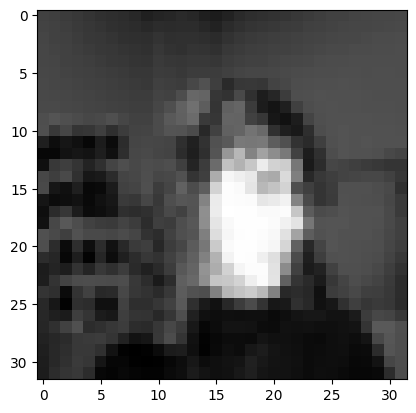

In [11]:
single_img = images[0] / 2 + 0.5  # Unnormalize a single image
plt.imshow(single_img.numpy().squeeze(), cmap='gray')  # Assuming the image is grayscale
plt.show()


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img):
    # Unnormalize
    img = img / 2 + 0.5     # This is to reverse the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
# Print labels for the displayed images
print('Labels: ', ' '.join(f'{labels[j].item()}' for j in range(4)))


In [2]:
from tqdm import tqdm  # tqdm is a library for making loops show a smart progress meter

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        data, target = data.to(device), [t.to(device) for t in target]
        optimizer.zero_grad()
        output_mitchell, output_expression = model(data)
        loss_mitchell = F.cross_entropy(output_mitchell, target[0])  # Assuming target[0] is for Mitchell
        loss_expression = F.cross_entropy(output_expression, target[1])  # Assuming target[1] is for expression
        loss = loss_mitchell + loss_expression
        loss.backward()
        optimizer.step()
        # Log training status here

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct_mitchell = 0
    correct_expression = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), [t.to(device) for t in target]
            output_mitchell, output_expression = model(data)
            # Calculate test loss and accuracy here

    # Log testing status here


In [23]:
import sys

def main():
    # Define default argument values
    data_dir = './faces'
    epochs = 10
    lr = 0.01
    no_cuda = False

    use_cuda = not no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load your data and split here
    dataset = ImageFolder(root=data_dir, loader=img_loader, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

       
if __name__ == '__main__':
    # When running as a script, pass the actual command line arguments
    main()

ValueError: Expected input batch_size (64) to match target batch_size (0).